# **<span style="color: #87CEEB;"> Brain Tumour Segmentation - VAE </span>**

# <span style="color: #9370DB;">**Deep Learning - 2025**</span>




In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

In [95]:
BATCH_SIZE = 10

<hr>

## <h1><b> Autoencoder for image segmentation <span style="color: #9370DB;"> </span></b></h1>  

<hr>

In [ ]:
image_dir = "images"
ground_truths_dir = "masks"

# Function for preprocessing images and masks
def preprocessing(image, mask):
    '''
    The purpose of this function is to apply necessary preprocessing steps to both the input images
    and their corresponding ground truth masks before they are used for model training.
    '''
    # ============ code here ============= #
    target_size = (512, 512)

    transform_image = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    transform_mask = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(target_size),
        transforms.ToTensor()
    ])

    image = transform_image(image)
    mask = transform_mask(mask)

    mask = (mask > 0.5).float()

    return image, mask


In [ ]:
# Load images and ground truths
data = list()
ground_truths = list()

'''
1. Load all image files and the corresponding ground truth mask files from their respective directories.
2. Read the images and masks and apply pre-processing (if any).
3. Append the preprocessed images to the `data` list and the corresponding masks to the `ground_truths`
   list (both list have initialized above).

Make sure each image correctly corresponds to its mask.
'''
# ============ code here ============= #
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(ground_truths_dir))

for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join(image_dir, img_file)
    mask_path = os.path.join(ground_truths_dir, mask_file)

    image = Image.open(img_path)
    mask = Image.open(mask_path)

    image, mask = preprocessing(image, mask)

    data.append(image)
    ground_truths.append(mask)


In [ ]:
'''
1. Create a train-val-test split using DataLoader (ideally 70% test, 20% val, and 10% test
   would be okay but upto you to come up with your own split composition).
2. You may use train_test_split() function (imported above) for splitting, but if you're
   comfortable with split strategies, that's totally fine.
3. Once splitted, use DataLoader class to load the datasets.
'''
dataset = TensorDataset(torch.stack(data), torch.stack(ground_truths))
total_samples = len(dataset)
# 80 10 10 split
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Print number of images in each set
print(f"train batches: {len(train_loader)*BATCH_SIZE} ({len(train_loader)/3065*BATCH_SIZE*100}%)")
print(f"val batches: {len(val_loader)*BATCH_SIZE} ({len(val_loader)/3065*BATCH_SIZE*100}%)")
print(f"test batches: {len(test_loader)*BATCH_SIZE} ({len(test_loader)/3065*BATCH_SIZE*100}%)")

# you may define your own variable names for loaders (names used above are just samples)

train batches: 2460 (80.26101141924958%)
val batches: 310 (10.114192495921698%)
test batches: 310 (10.114192495921698%)


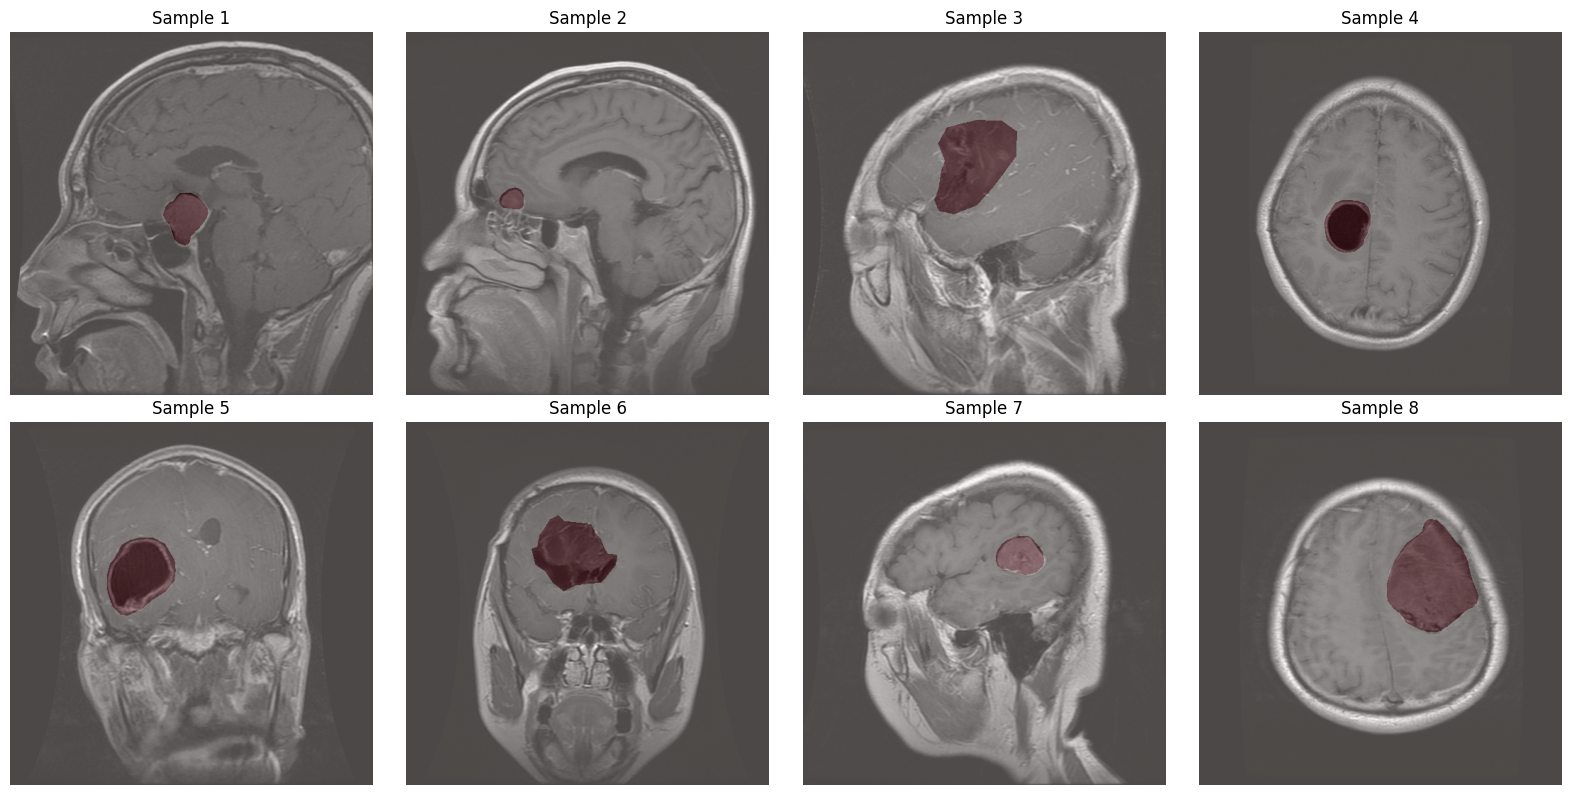

In [100]:
'''
Once you're done making the dataset, use the function below to vizualize it.
'''
def visualize_samples(images, masks):
    num_samples = len(images)
    fig, axes = plt.subplots(nrows=2, ncols=num_samples // 2, figsize=(16, 8))

    for i, (image, mask) in enumerate(zip(images, masks)):
        image = image.squeeze(0)
        mask = mask.squeeze(0)
        ax = axes[i // (num_samples // 2), i % (num_samples // 2)]
        ax.imshow(image, cmap='gray')
        ax.imshow(mask, alpha=0.3, cmap='Reds')
        ax.axis('off')
        ax.set_title(f'Sample {i+1}')
    plt.tight_layout()
    plt.show()


# Select 8 random samples from the training dataset
random_indices = np.random.choice(len(train_set), 8, replace=False)
random_samples = [(train_set[i][0], train_set[i][1]) for i in random_indices]

# Separate images and masks
random_images = [sample[0] for sample in random_samples]
random_masks = [sample[1] for sample in random_samples]

visualize_samples(random_images, random_masks)


In [ ]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()


    def forward(self, prediction, target):
        # Code here
        prediction = prediction.view(-1)
        target = target.view(-1)
        s=1e-6
        intersection = (prediction * target).sum()
        dice_loss = 1 - (2 * intersection + s) / (prediction.pow(2).sum() + target.pow(2).sum() + s)
        return dice_loss


In [ ]:
class SegmentationAE(nn.Module):
    def __init__(self):
        super(SegmentationAE, self).__init__()

        # --- Encoder ---
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # --- Decoder ---
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 1, kernel_size=7, stride=2, padding=3, output_padding=1),
            nn.Sigmoid()
        )



    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Instantiate randomly and print summary (size of your model, no. params and stuff)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu') # MPS is available or not - Only for Macbook M1 and above
model = SegmentationAE().to(device)
# model_cpu = model.to("cpu")
summary(model, input_size=(1, 256, 256), batch_size=BATCH_SIZE,device=str(device))
# model = model_cpu.to(device)

# def get_num_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)
# total_params = get_num_parameters(model)
# print("Total number of trainable parameters:", total_params)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [10, 32, 256, 256]           1,600
              ReLU-2         [10, 32, 256, 256]               0
         MaxPool2d-3         [10, 32, 128, 128]               0
            Conv2d-4         [10, 64, 128, 128]          51,264
              ReLU-5         [10, 64, 128, 128]               0
         MaxPool2d-6           [10, 64, 64, 64]               0
            Conv2d-7          [10, 128, 64, 64]          73,856
              ReLU-8          [10, 128, 64, 64]               0
         MaxPool2d-9          [10, 128, 32, 32]               0
           Conv2d-10          [10, 256, 32, 32]         295,168
             ReLU-11          [10, 256, 32, 32]               0
        MaxPool2d-12          [10, 256, 16, 16]               0
           Conv2d-13          [10, 512, 16, 16]       1,180,160
             ReLU-14          [10, 512,

### **Task 4: Define the Training Loop**  

- Print both the training and validation losses for each epoch.  
- Plot the training and validation loss curves, with epochs on the x-axis and losses on the y-axis, at the end of the training.  
- Save the best model as a `.pth` file using the `torch.save()` method. **Submit this file along with your notebook, naming it as `campus_id.pth`.**  
- After every 2ish epochs, visualize a grid displaying the Image | Ground Truth Mask | Predicted Mask.


Epoch 1/10 - Train Loss: 0.7605, Val Loss: 0.6408
Epoch 2/10 - Train Loss: 0.6263, Val Loss: 0.6985


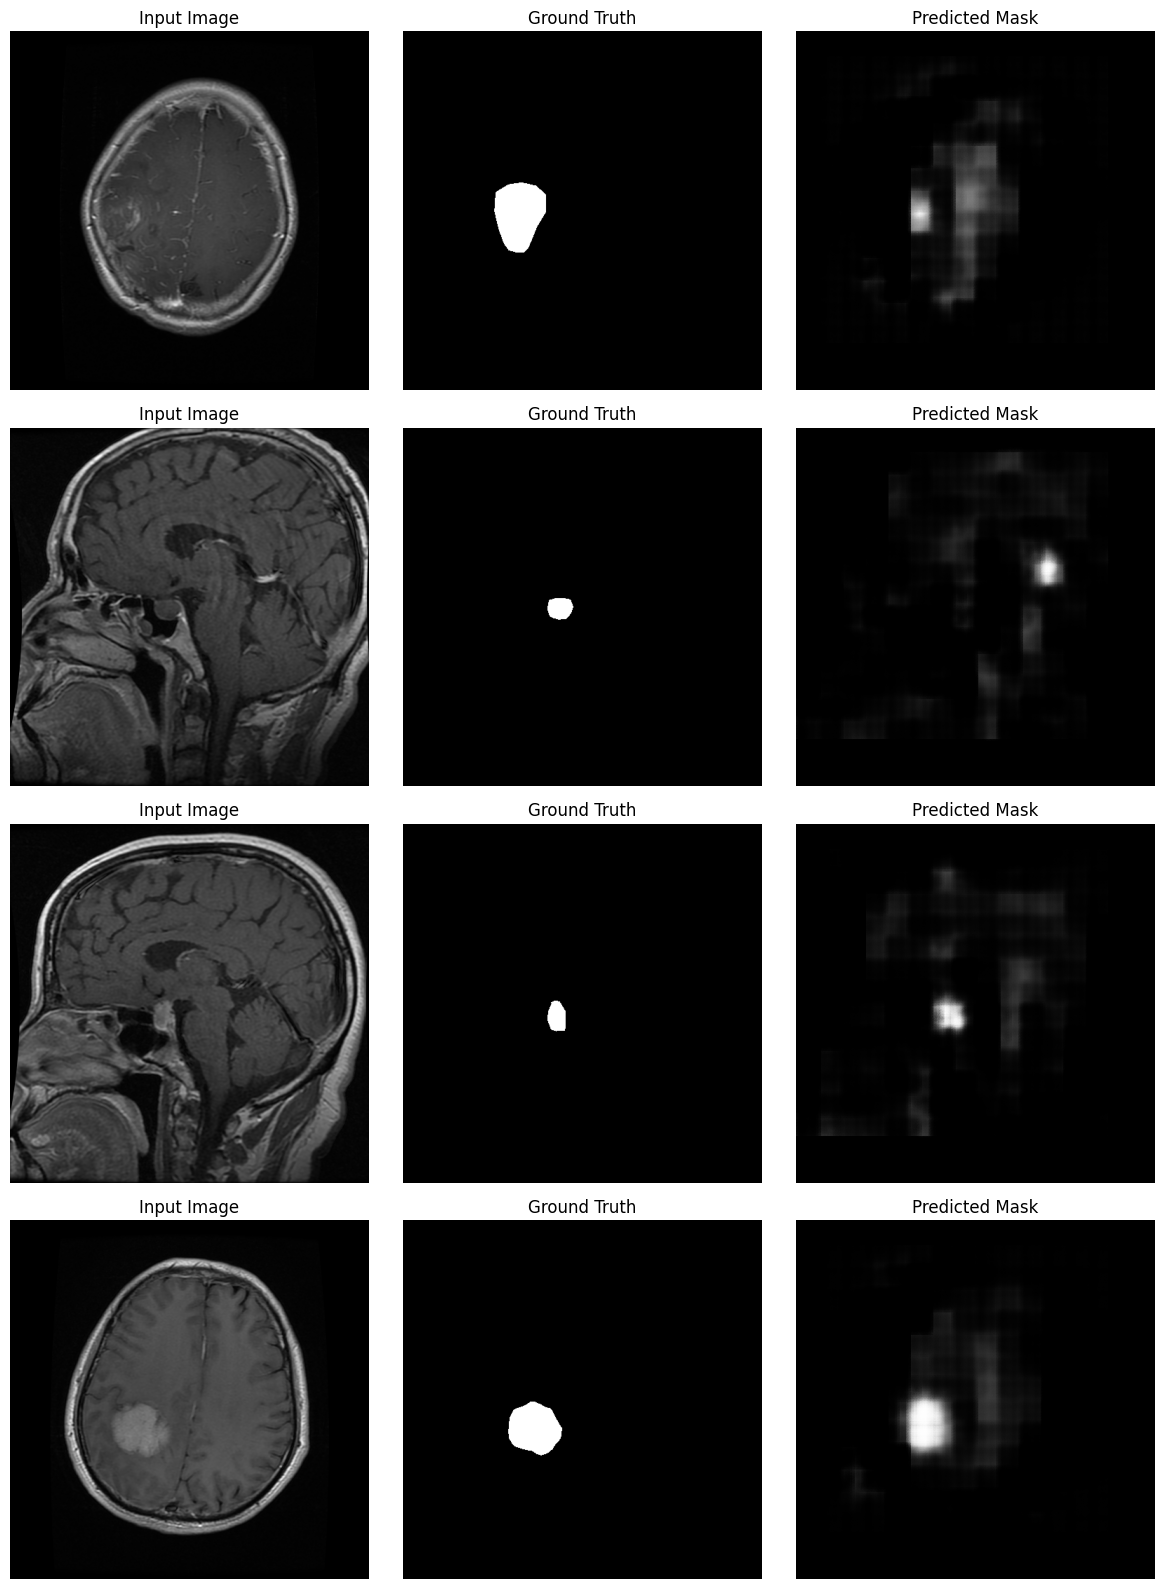

Epoch 3/10 - Train Loss: 0.5161, Val Loss: 0.4542
Epoch 4/10 - Train Loss: 0.4393, Val Loss: 0.3622


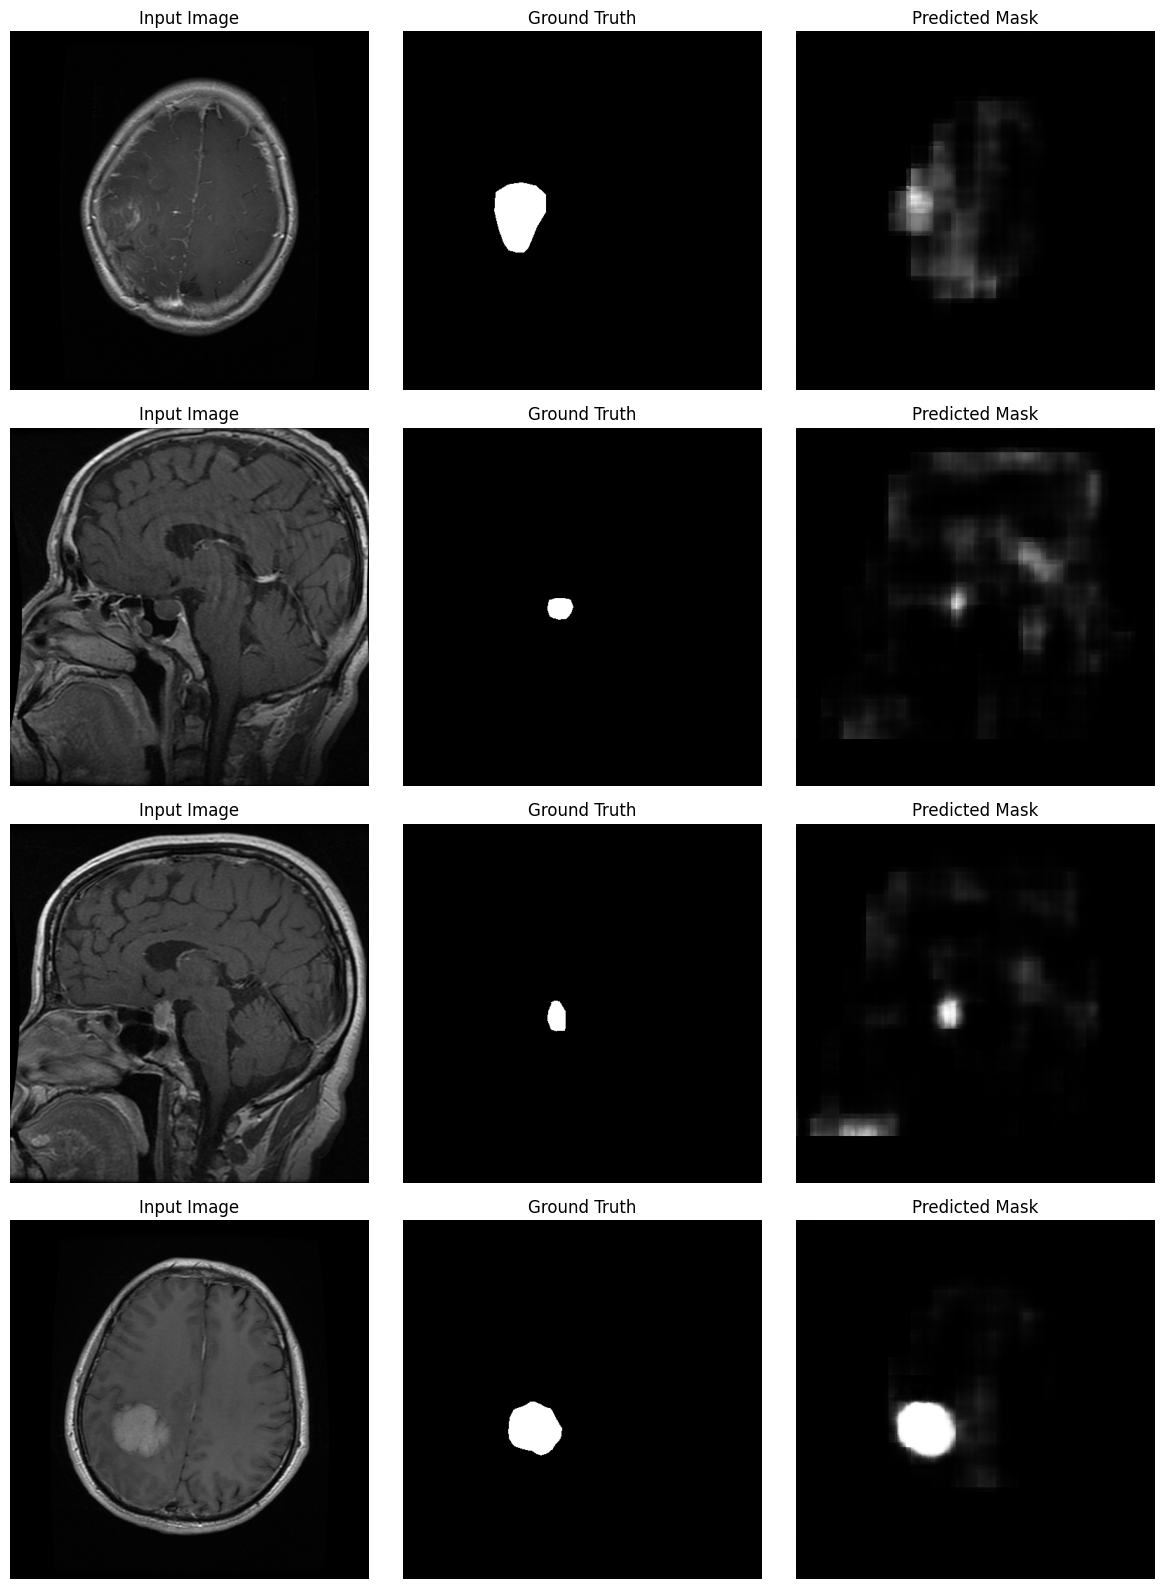

Epoch 5/10 - Train Loss: 0.3689, Val Loss: 0.3495
Epoch 6/10 - Train Loss: 0.3233, Val Loss: 0.2860


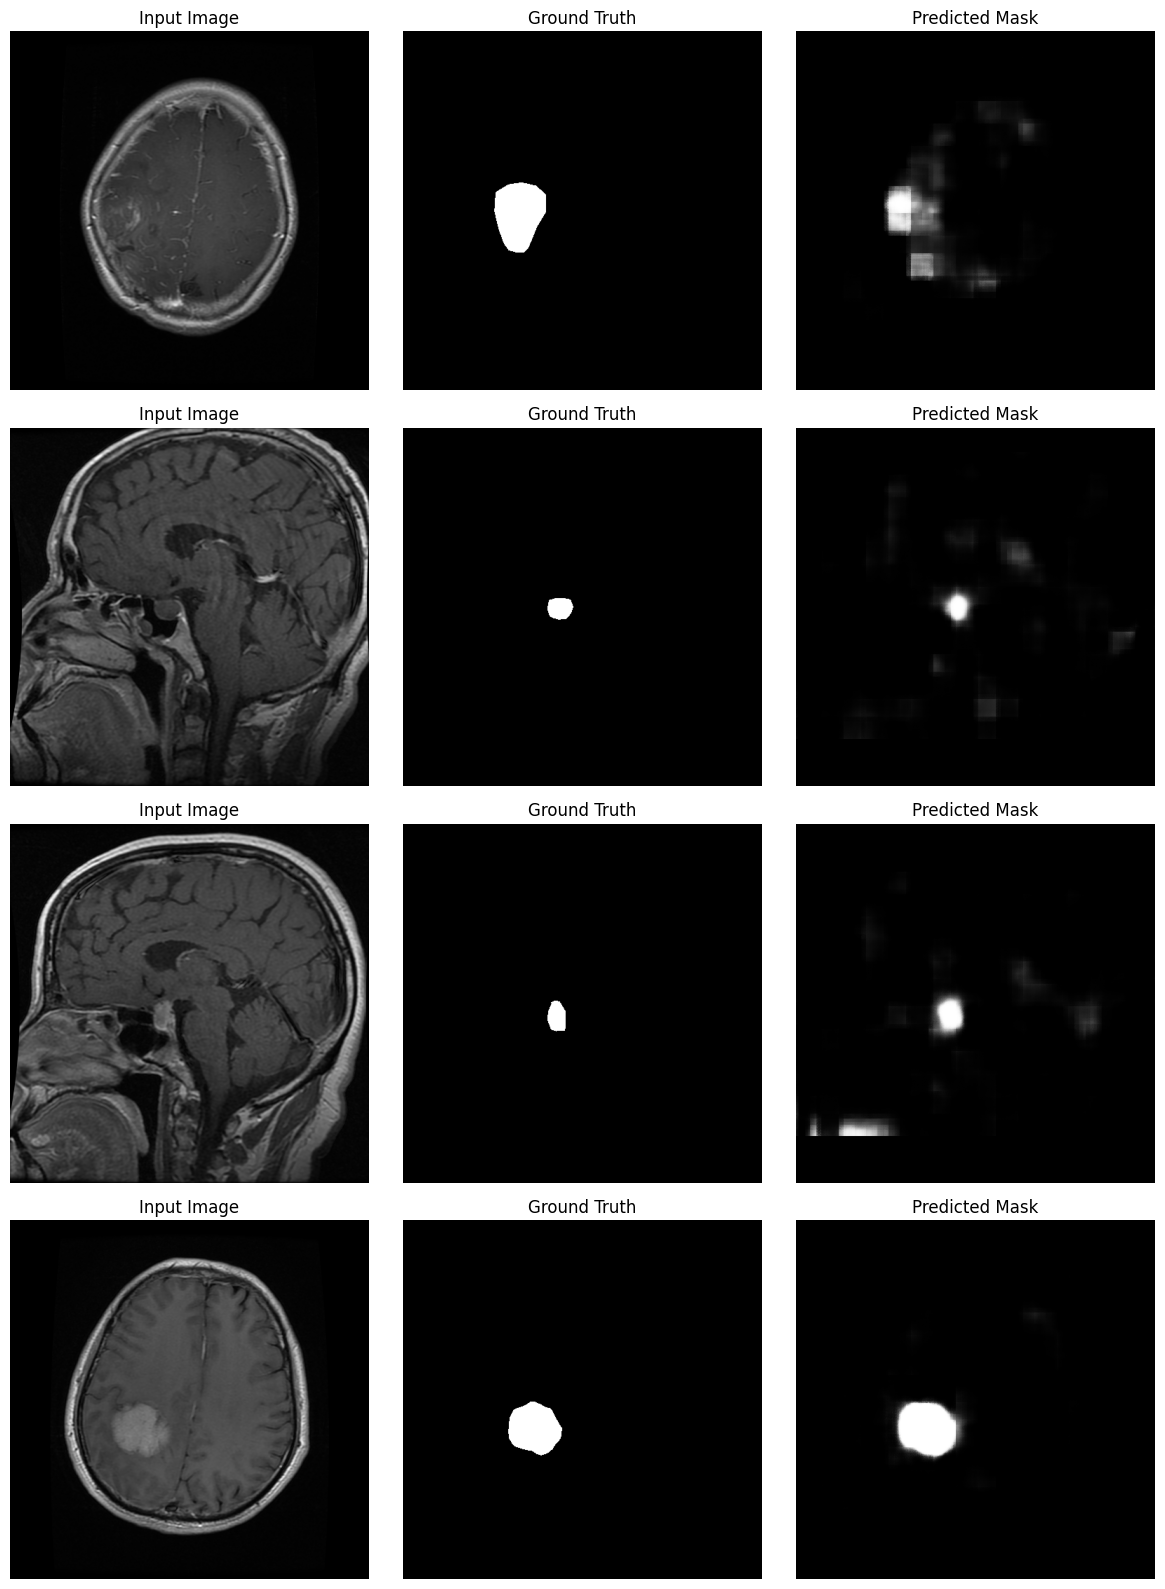

Epoch 7/10 - Train Loss: 0.2687, Val Loss: 0.3265
Epoch 8/10 - Train Loss: 0.2492, Val Loss: 0.2839


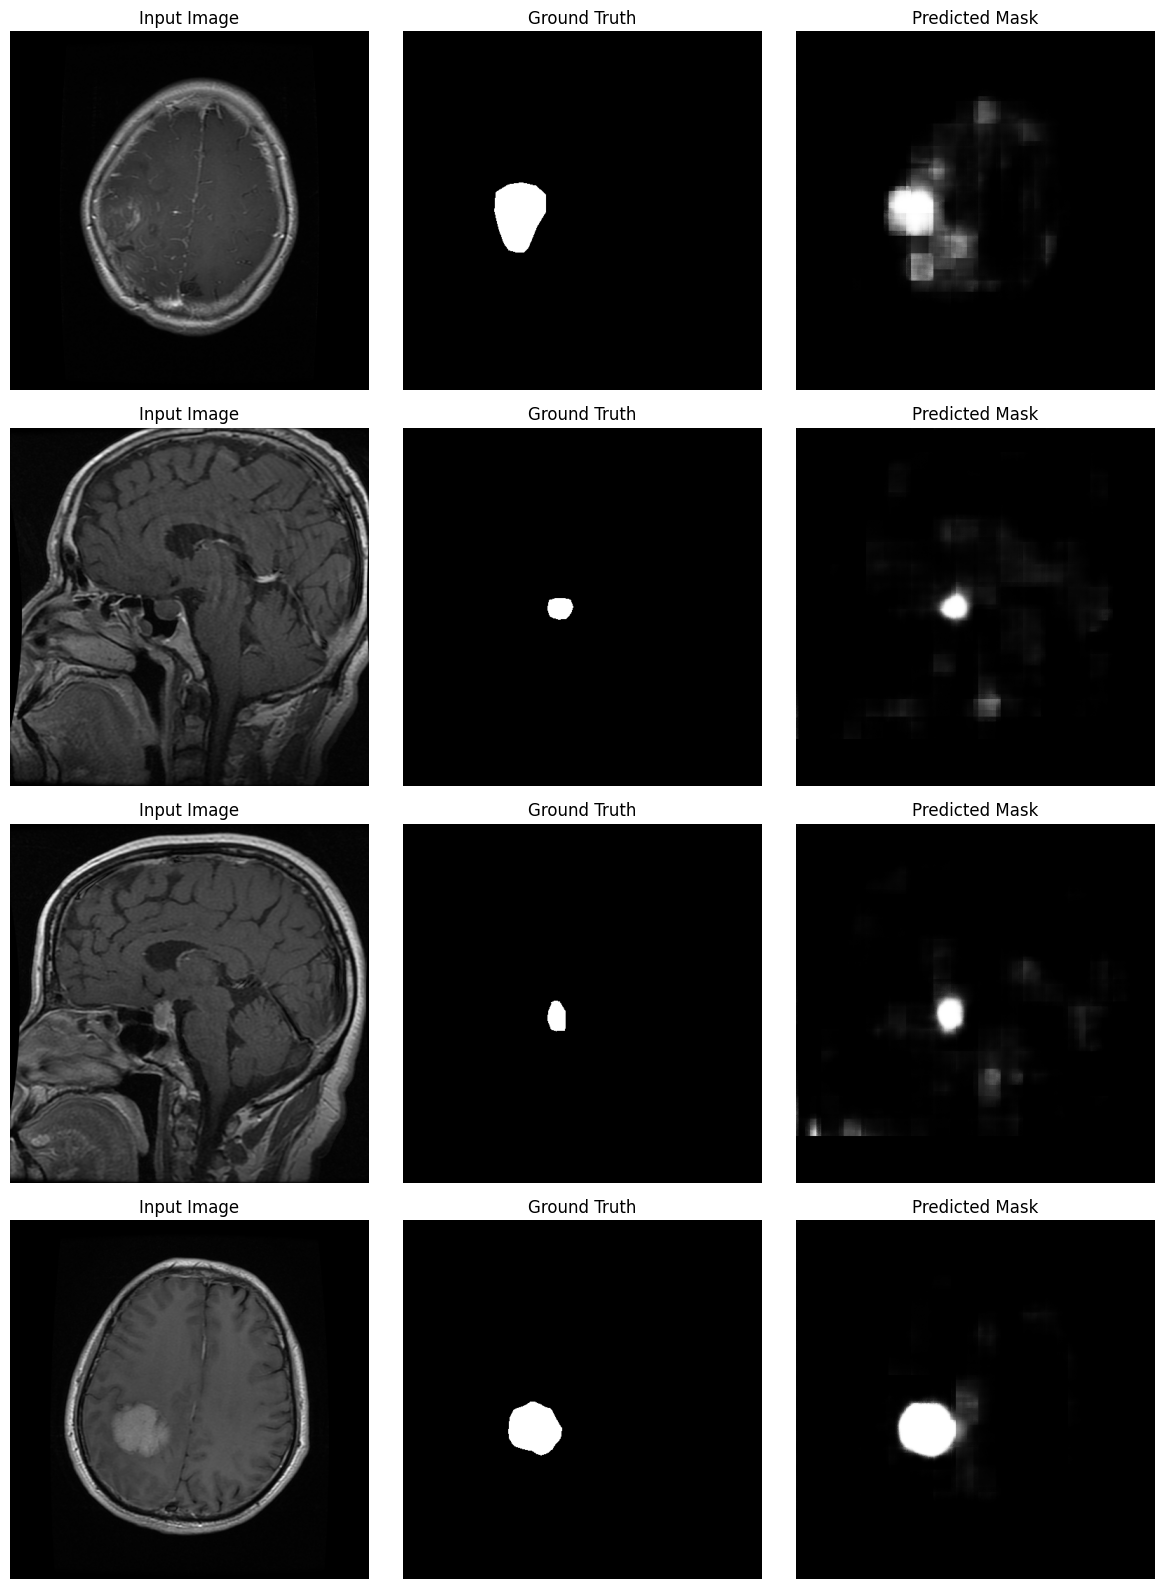

Epoch 9/10 - Train Loss: 0.2147, Val Loss: 0.2744
Epoch 10/10 - Train Loss: 0.1830, Val Loss: 0.2752


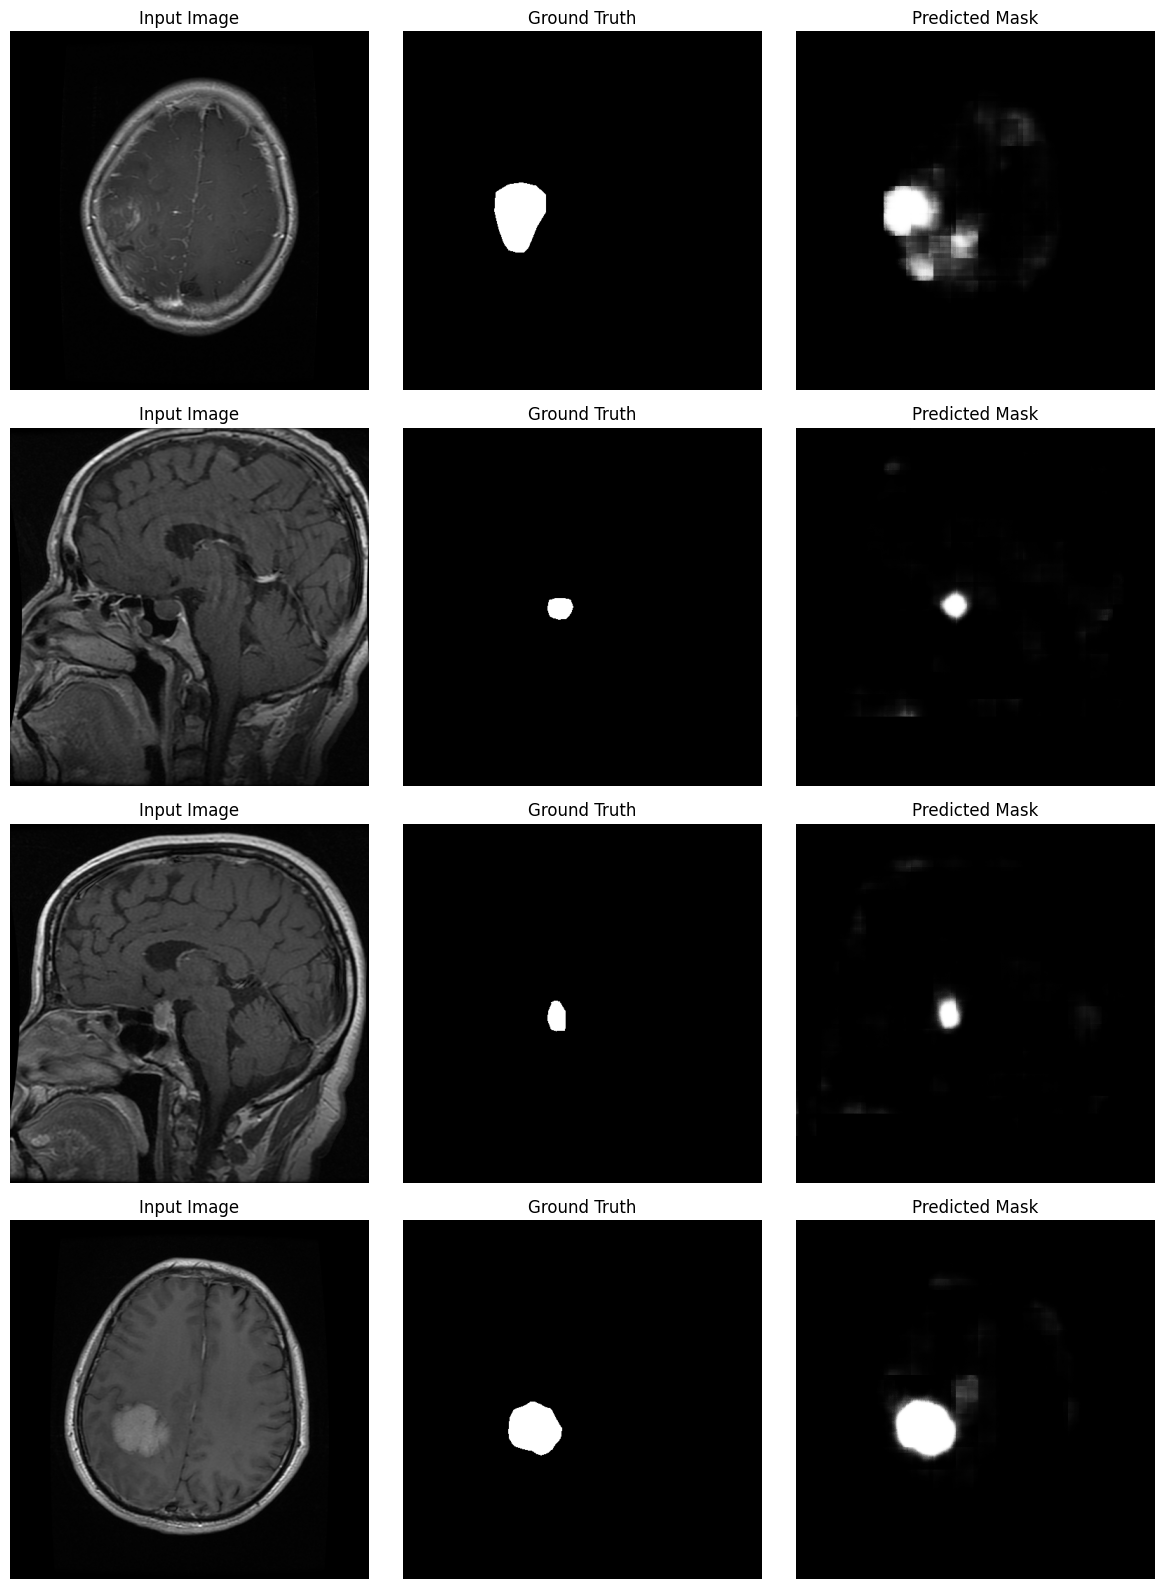

In [ ]:
# ----------------------------
# 1. Setup: define criterion, optimizer, and number of epochs
# ----------------------------
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
# ============ code here ============= #
train_losses = []
val_losses = []
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for img, masks in train_loader:
        img = img.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(img)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * img.size(0)
    epoch_train_loss = running_train_loss / len(train_set)
    train_losses.append(epoch_train_loss)

    model.eval()
    ccurr_loss = 0.0
    with torch.no_grad():
        for img, masks in val_loader:
            img = img.to(device)
            masks = masks.to(device)
            outputs = model(img)
            loss = criterion(outputs, masks)
            ccurr_loss += loss.item() * img.size(0)
    epoch_val_loss = ccurr_loss / len(val_set)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    if epoch_val_loss < best_loss:
        best_loss = epoch_val_loss
        torch.save(model.state_dict(), "26100076_PA2_3.pth")

    # if (epoch + 1) % 5 == 0:
    if (epoch + 1) % 2 == 0:
        img, masks = next(iter(val_loader))
        img = img.to(device)
        masks = masks.to(device)
        model.eval()
        with torch.no_grad():
            preds = model(img)

        n = min(img.size(0), 4)
        fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(12, n * 4))
        for i in range(n):

            ax = axes[i, 0]
            ax.imshow(img[i].cpu().squeeze(0), cmap='gray')
            ax.set_title("Input Image")
            ax.axis("off")

            ax = axes[i, 1]
            ax.imshow(masks[i].cpu().squeeze(0), cmap='gray')
            ax.set_title("Ground Truth")
            ax.axis("off")

            ax = axes[i, 2]
            ax.imshow(preds[i].cpu().squeeze(0), cmap='gray')
            ax.set_title("Predicted Mask")
            ax.axis("off")
        plt.tight_layout()
        plt.show()


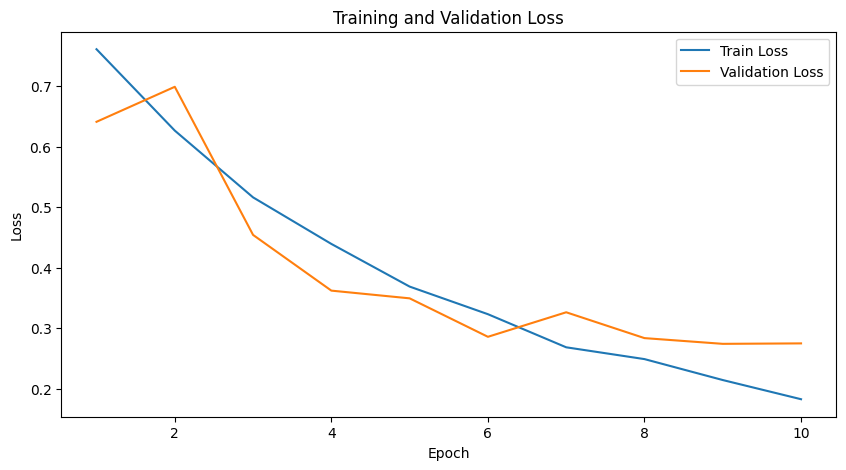

In [104]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
def dice_coef(groundtruth_mask, pred_mask):
    PuT = np.sum(pred_mask * groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    if total_sum > 0:
        dice = (2 * PuT) / total_sum
    else:
        dice = 1.0
    return dice

def iou(groundtruth_mask, pred_mask):
    PuT = np.sum(pred_mask) + np.sum(groundtruth_mask) - np.sum(pred_mask * groundtruth_mask)
    iou_value = np.sum(pred_mask * groundtruth_mask) / PuT
    return iou_value

C:\Users\Taha Faisal\AppData\Local\Temp\ipykernel_17932\3517159579.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("26100076.pth"))


Average Dice Coefficient on Test Set: 0.6395
Average IoU on Test Set: 0.5270


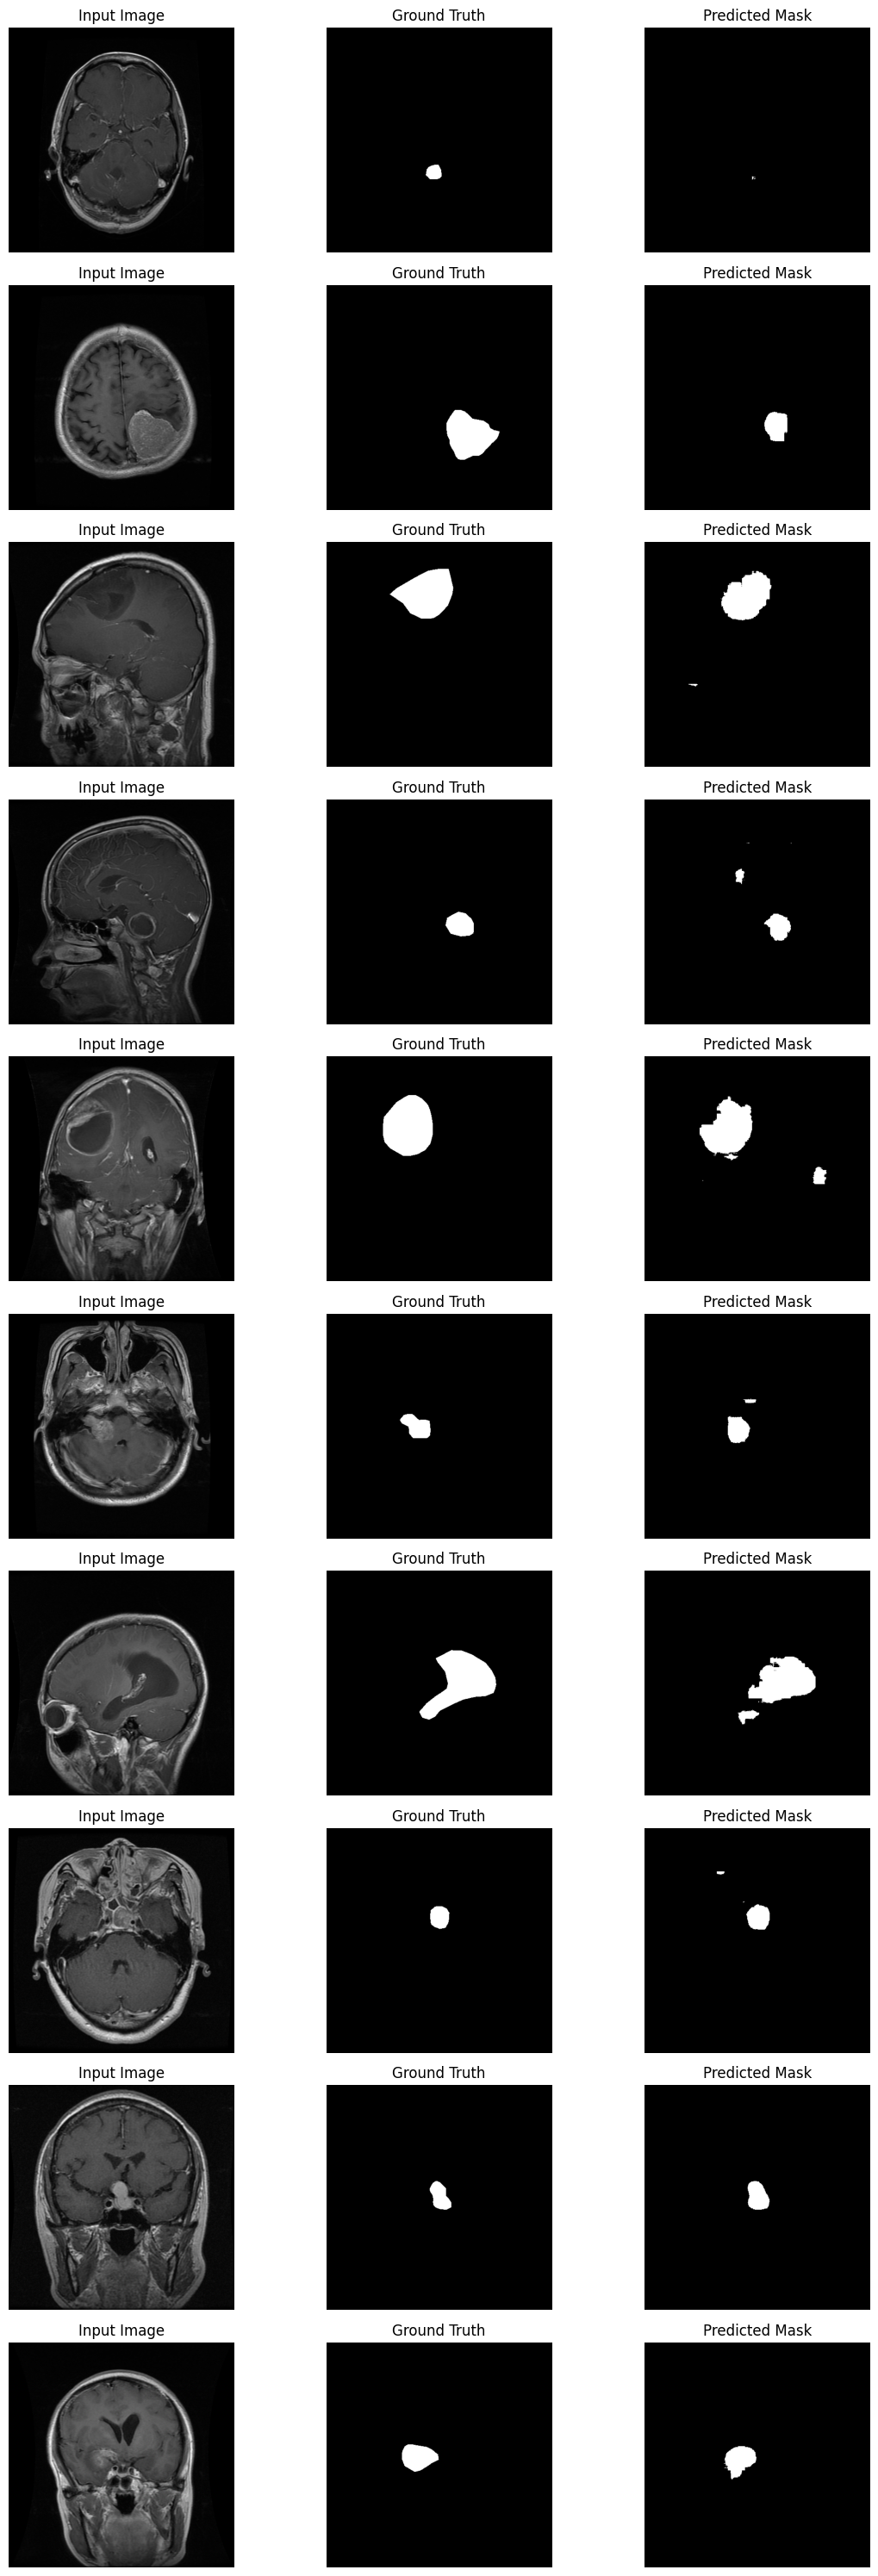

In [ ]:
## code here
model.load_state_dict(torch.load("26100076_PA2_3.pth"))
model.eval()
all_dice = []
all_iou = []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        outputs = (outputs > 0.5).float()

        for i in range(images.size(0)):
            gt = masks[i].cpu().numpy().squeeze()
            pred = outputs[i].cpu().numpy().squeeze()
            d = dice_coef(gt, pred)
            iou_val = iou(gt, pred)
            all_dice.append(d)
            all_iou.append(iou_val)

avg_dice = np.mean(all_dice)
avg_iou = np.mean(all_iou)

print(f"Average Dice Coefficient on Test Set: {avg_dice:.4f}")
print(f"Average IoU on Test Set: {avg_iou:.4f}")

num_samples = 10
ind = random.sample(range(len(test_set)), num_samples)

fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 3))
for i, idx in enumerate(ind):
    image, gtm = test_set[idx]
    image_input = image.unsqueeze(0).to(device)
    with torch.no_grad():
        pred_mask = model(image_input)

    pred_mask = (pred_mask > 0.5).float().cpu().squeeze().numpy()

    image_np = image.cpu().squeeze().numpy()
    gtm_np = gtm.cpu().squeeze().numpy()

    axes[i, 0].imshow(image_np, cmap='gray')
    axes[i, 0].set_title("Input Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(gtm_np, cmap='gray')
    axes[i, 1].set_title("Ground Truth")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(pred_mask, cmap='gray')
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()
